# STL and ARIMA

In [9]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import plotly.express as px
from sklearn.utils import resample  # For bootstrapping
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA


## Load data

In [10]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1571,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False
1572,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False
1573,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False
1574,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False


## STL and ARIMA

In [11]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 129
Outlier cases: 119


In [12]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Set Outlier values to missing
df.loc[df['Outlier'], 'Revenue Losses'] = None

# While loop to fill with 7 day lags
# Alternate between computing 7 day lags
# and filling missing values with 7 day lags
while df['Revenue Losses'].isnull().sum() > 0:
    # Compute 7 day lags
    df['7-day lag'] = df['Revenue Losses'].shift(7)
    # Fill missing values with 7 day lags
    df['Revenue Losses'] = df['Revenue Losses'].fillna(df['7-day lag'])

In [ ]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [ ]:
# For this model, limit data to last year
# This will both take care of outliers and minimize missing data
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=1)].reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train,Missing,7-day lag
0,2024-02-16,241.0,3974.0,6.064419,1012500.0,True,True,False,1012500.0
1,2024-02-17,1511.0,15466.0,9.769818,944375.0,False,True,False,950625.0
2,2024-02-18,1816.0,15880.0,11.435768,1135000.0,False,True,False,1088125.0
3,2024-02-19,2004.0,15851.0,12.642735,1252500.0,False,True,False,1136875.0
4,2024-02-20,1908.0,15908.0,11.993965,1192500.0,False,True,False,1083125.0
...,...,...,...,...,...,...,...,...,...
362,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False,False,773125.0
363,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False,False,736875.0
364,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False,False,679375.0
365,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False,False,694375.0


In [ ]:
# Count missing and outlier cases
print('Missing cases:', df['Missing'].sum())
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 35


In [ ]:
df = df[['Date', 'Revenue Losses', 'Train']]
df

,Date,Revenue Losses,Train
0,2024-02-16,1012500.0,True
1,2024-02-17,944375.0,True
2,2024-02-18,1135000.0,True
3,2024-02-19,1252500.0,True
4,2024-02-20,1192500.0,True
...,...,...,...
362,2025-02-12,798125.0,False
363,2025-02-13,743125.0,False
364,2025-02-14,667500.0,False
365,2025-02-15,691875.0,False


In [ ]:
# Train/test split
train_df = df.query('Train == 1').reset_index(drop=True)
test_df = df.query('Train == 0').reset_index(drop=True)
print(len(train_df), len(test_df))

337 30


In [ ]:
# 1. STL Decomposition
decomposition = seasonal_decompose(train_df['Revenue Losses'], model='additive')  # Or multiplicative
seasonally_adjusted = decomposition.resid

# 2. auto_arima on Seasonally Adjusted Data
auto_model = auto_arima(seasonally_adjusted, seasonal=False,  # Important: seasonal=False
                        stepwise=True, trace=True,
                        suppress_warnings=True, error_action='ignore')
best_order = auto_model.order  # Get the best (p, d, q) order
print('optimal order: ', best_order)

# 3. STLForecast with the Determined Order
stlf = STLForecast(train_df['Revenue Losses'], ARIMA, model_kwargs={"order": best_order}) # Use the found order
stlf_fitted = stlf.fit()

# Get forecast
test_forecast = stlf_fitted.forecast(30)

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
# Check residuals
def plot_stlforecast_residuals(fit, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for STLForecast.

    Args:
        fit: The fitted STLForecast model object (result of fit()).
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    residuals = fit.resid  # Access residuals from the fit object
    fitted_values = fit.fittedvalues # Access fitted values from the fit object

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')  # Or time index
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2,1]) # Remove the unnecessary subplot

    plt.tight_layout()
    plt.show()

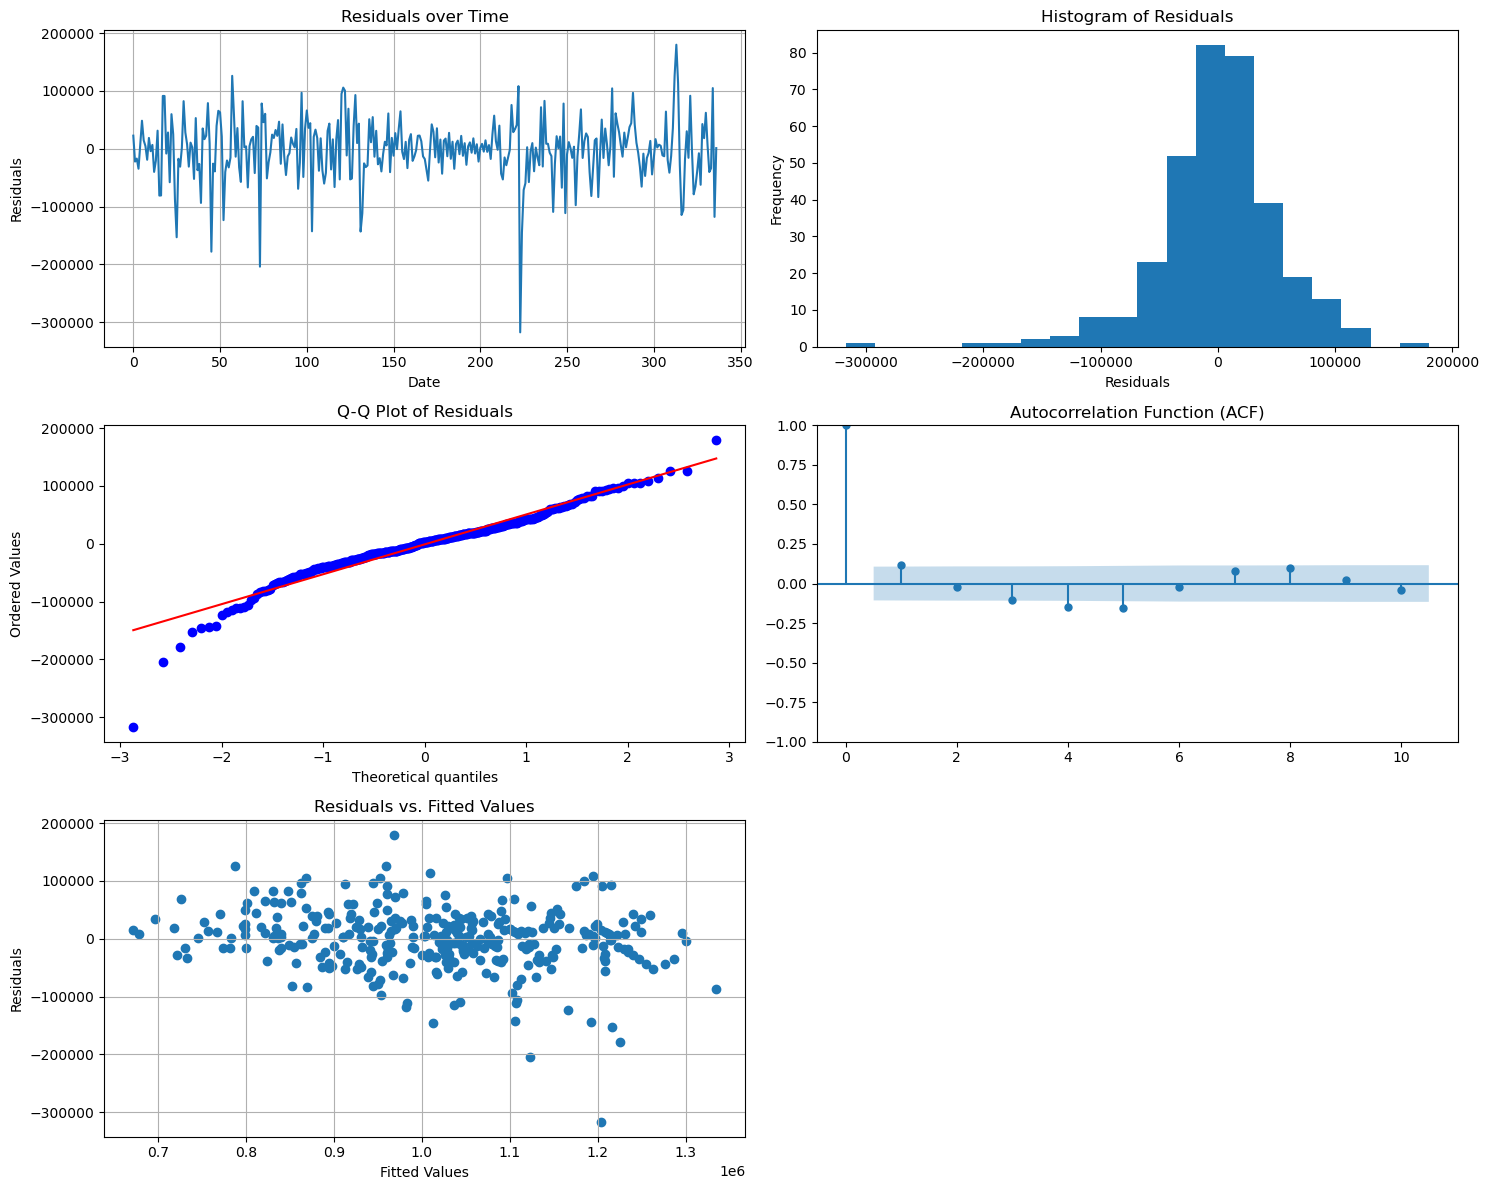

In [ ]:
plot_stlforecast_residuals(stlf_fitted)

In [ ]:
# 1. Get Residuals from the Training Data
train_residuals = train_df['Revenue Losses'] - stlf_fitted.fittedvalues

# 2. Bootstrapping Function
def bootstrap_forecast(train_data, train_residuals, test_len, n_bootstraps=500):
    forecasts = []
    for _ in range(n_bootstraps):
        # 2a. Resample Residuals with Replacement
        resampled_residuals = list(resample(train_residuals, replace=True))

        # 2b. Create "Bootstrapped" Training Data
        bootstrapped_train = train_data + resampled_residuals

        # Forecasting steps:

        # 1. STL Decomposition
        boot_decomposition = seasonal_decompose(bootstrapped_train, model='additive')  # Or multiplicative
        boot_seasonally_adjusted = boot_decomposition.resid

        # 2. auto_arima on Seasonally Adjusted Data
        boot_auto_model = auto_arima(boot_seasonally_adjusted, seasonal=False,  # Important: seasonal=False
                                stepwise=True, trace=True,
                                suppress_warnings=True, error_action='ignore')
        boot_best_order = boot_auto_model.order  # Get the best (p, d, q) order
        print('optimal order: ', boot_best_order)

        # 3. STLForecast with the Determined Order
        boot_stlf = STLForecast(bootstrapped_train, ARIMA, model_kwargs={"order": best_order}) # Use the found order
        boot_stlf_fitted = boot_stlf.fit()

        # Get forecast
        boot_forecast = boot_stlf_fitted.forecast(30)
        forecasts.append(boot_forecast)

    return np.array(forecasts)  # Return as a NumPy array for easier manipulation

# 3. Generate Bootstrapped Forecasts
n_bootstraps = 500  # Number of bootstrap iterations (adjust as needed)
boot_forecasts = bootstrap_forecast(train_df['Revenue Losses'], train_residuals, len(test_df), n_bootstraps)

# 4. Calculate Prediction Intervals
alpha = 0.05  # Significance level (for 95% interval)
lower_bounds = np.percentile(boot_forecasts, (alpha / 2) * 100, axis=0)  # Lower percentile
upper_bounds = np.percentile(boot_forecasts, (1 - alpha / 2) * 100, axis=0)  # Upper percentile

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\ijyli\.local\share\ma

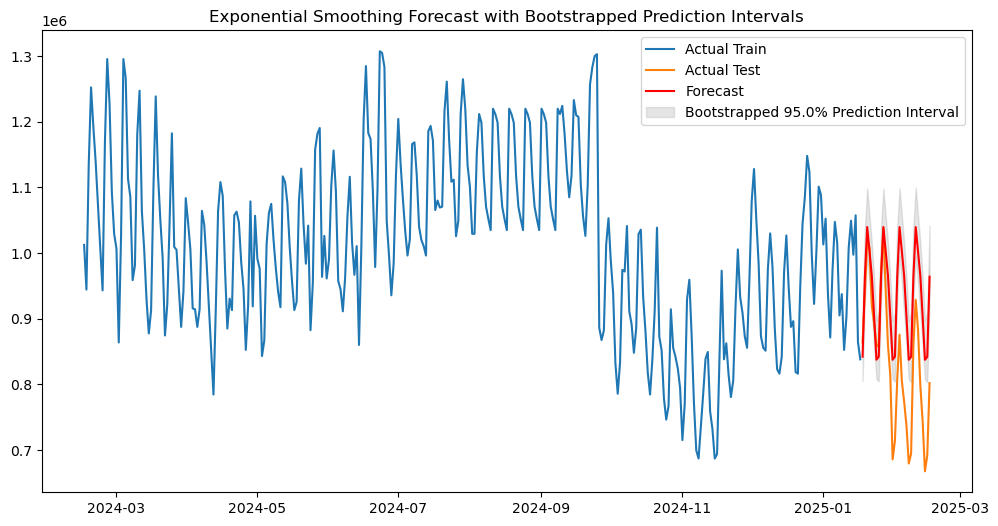

In [ ]:
# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Revenue Losses'], label='Actual Train')
plt.plot(test_df['Date'], test_df['Revenue Losses'], label='Actual Test')
plt.plot(test_df['Date'], test_forecast, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_bounds, upper_bounds, color='gray', alpha=0.2, label=f'Bootstrapped {100*(1-alpha)}% Prediction Interval')

plt.title('STL-ARIMA Forecast with Bootstrapped Prediction Intervals')
plt.legend()
plt.show()

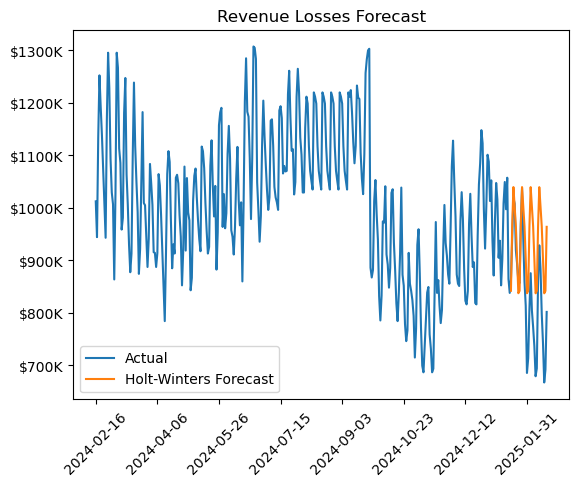

MAE: 101173.90697874178
RMSE: 120677.05269360436


In [ ]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="STL-ARIMA Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
rmse = root_mean_squared_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)
print('RMSE:', rmse)

NOTES.